In [3]:
# import Class
from classy import Class
import numpy as np
# to get plots displayed in notebook
%matplotlib notebook
import matplotlib.pyplot as plt
from math import pi
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({'omega_b':0.022032,'omega_cdm':0.12038,'h':0.67556,'A_s':2.215e-9,'n_s':0.9619,'tau_reio':0.0925})
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0}) # run class
LambdaCDM.compute()

In [70]:
kk = np.logspace(-4, np.log10(3.), 240) 
Pk = []
for k in kk:
    Pk.append(LambdaCDM.pk(k,0.)) 

<IPython.core.display.Javascript object>


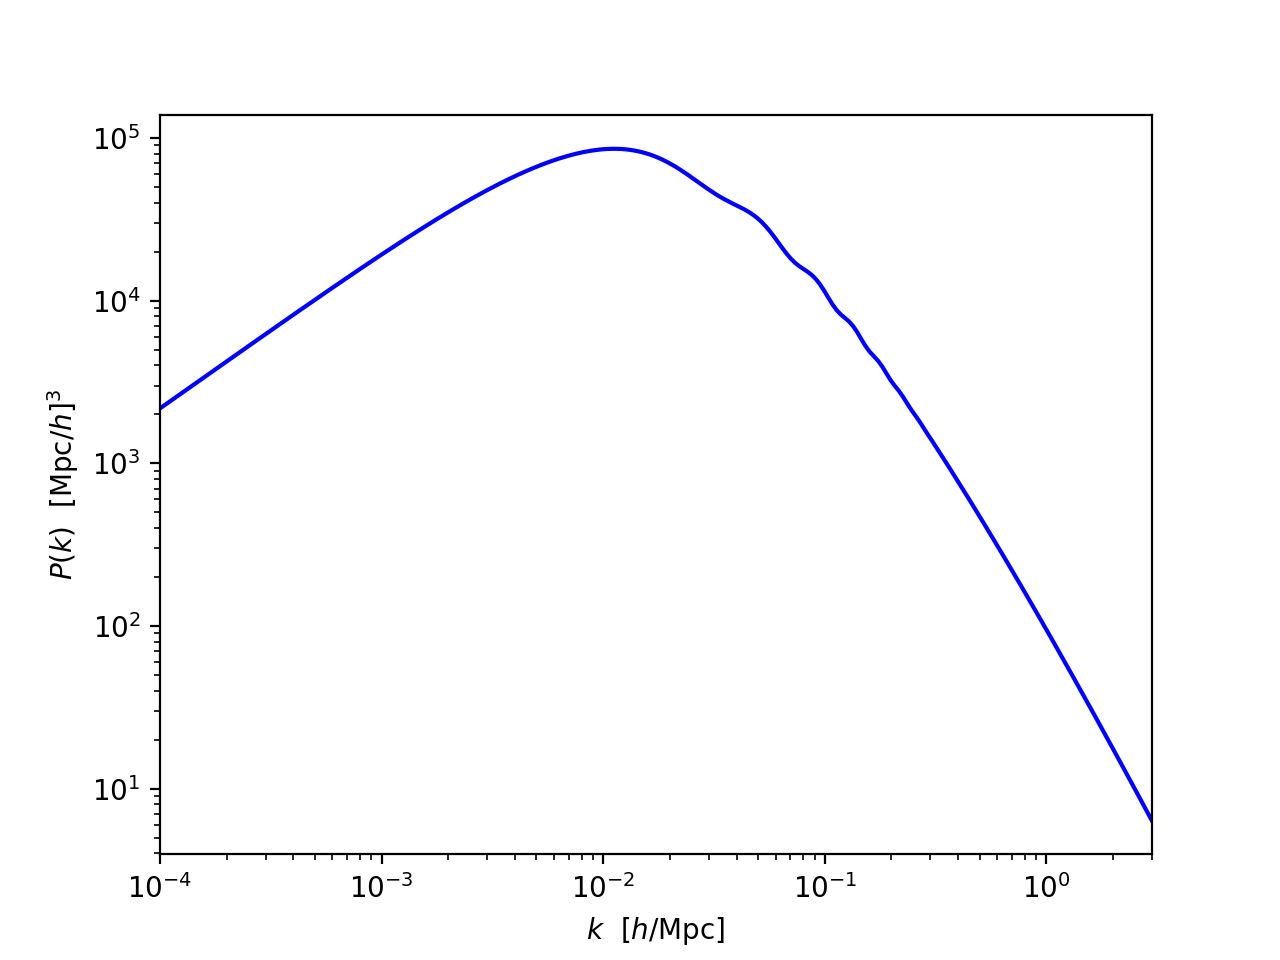

In [71]:
# plot P(k)
plt.figure() 
plt.xscale('log')
plt.yscale('log')
plt.xlim(kk[0],kk[-1]) 
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$') 
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$') 
plt.plot(kk,Pk,'b-')

In [72]:
np.savetxt('Pk.dat', np.c_[kk,Pk])

In [73]:
# load corrections to Pk
lcdm_c = np.genfromtxt("/Users/aizhan.akh/Documents/Projects/PT-check/code/P_1loop.dat")
kk_c = lcdm_c[:, 0]
Pk_c = lcdm_c[:, 1]

lcdm_interp = np.interp(kk_c, kk, Pk)
lcdm_new = Pk_c + lcdm_interp

In [97]:
def pk_nonlinear(k, P0):
    
    import numpy as np
    from numpy.fft import fft, ifft , rfft, irfft , fftfreq
    from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt
    from scipy.special import gamma
    from scipy.special import hyp2f1
    from scipy import interpolate
    import sys
    from time import time
    from scipy.integrate import quad
    import scipy.integrate as integrate
    from scipy import special
    from time import time
    from scipy.optimize import fsolve
    from scipy.special import factorial
    
    #name = str(file)
    #d=np.loadtxt(file)
    #d=np.loadtxt('/Users/michalychforever/Dropbox/Docs/science/class_public-2.5.0/output/cmassDR10_z2_pk.dat', skiprows = 4)
    #k=d[:,0]; P0=d[:,1]
    Plin = interpolate.InterpolatedUnivariateSpline(k,P0)
    
    Nmax = 240
    b = -0.3
    k0 = k[0]
    kmax = k[-1]
    kcutoff = 5.
    
    ### here I prepare kbins and sample the power spectrum
    
    Delta = log(kmax/k0) / (Nmax - 1)
    jsNm = np.arange(-Nmax/2,Nmax/2+1,1)
    etam = b + 2*1j*pi*(jsNm)/Nmax/Delta
    Pdiscrin = np.zeros(Nmax);
    Plin0 = np.zeros(Nmax);
    kbins3 = np.zeros(Nmax);
    for i in range(Nmax):
    	Pdiscrin[i] = Plin(k0 * exp(Delta * i)) * exp(-1.*b*i*Delta) 
    	kbins3[i] = k0 * exp(Delta * i)
    	Plin0[i] = Plin(kbins3[i])
    
    ### here I compute FFT coeffs, throw out high-freq harmonics and symmetrize the rest 
    
    cm = np.fft.fft(Pdiscrin)/ Nmax
    cmsym = [0 for i in range(Nmax+1)]
    for i in range(0, Nmax+1):
        if (i+2 - Nmax/2) < 1:
            cmsym[i] =  k0**(-etam[i])*np.conjugate(cm[int(-i + Nmax/2)])
        else:
    	       cmsym[i] = k0**(-etam[i])* cm[int(i - Nmax/2)]
    	
    cmsym[-1] = cmsym[-1] / 2
    cmsym[0] = cmsym[0] / 2
    
    ### here I define the functions which evaluate the non-linear matrices
    
    def Gamma(x):
        return special.gamma(x)
    
    
    def J(nu1,nu2):
        return (Gamma(1.5 - nu1) * Gamma(1.5 - nu2) * Gamma(nu1 + nu2 - 1.5) / (Gamma(nu1) * Gamma(nu2) * Gamma(3. - nu2 - nu1))) / (8. * pi**(1.5))
    
    
    def M13(nu1):
        return  (1 + 9 * nu1) * np.tan(nu1*pi)/(4. * 28. * pi * (nu1 + 1.) * nu1 * (nu1 - 1.) * (nu1 - 2.) * (nu1 - 3.))
    
    
    def M22(nu1,nu2):
        return (1.5 - nu1 - nu2) * (0.5 - nu1 - nu2) * (nu1*nu2*(98.*(nu1+nu2)**2.-14.*(nu1+nu2)+36.) - 91.*(nu1+nu2)**2. + 3.*(nu1 + nu2) + 58.)*J(nu1,nu2)/(196. * nu1 * (1. + nu1) * (0.5 - nu1) * nu2 * (1. + nu2) * (0.5 - nu2))
    
    
    ### here I compute the UV part of P13
    
    sigmaV = integrate.quad(lambda x: (4*pi)*Plin(x)/(3*(2*pi)**3), k0, k[-1])[0]
    def P13UV(x):
        return -61 * 1 * Plin(x) * x**2 * sigmaV / 105
    
    
    ### here I compute 1-loop PS = multiply the non-linear matrices and Fourier harmonics
    
    P13 = np.zeros(Nmax)
    m13 = np.zeros((Nmax+1),dtype=complex)
    b13 = np.zeros((Nmax+1),dtype=complex)
    for i in range(Nmax+1):
        m13[i] = M13(-0.5 * etam[i])
    
    t03 = time()
    
    
    for j in range(Nmax):
        for i in range(Nmax+1):
            b13[i] = cmsym[i]* kbins3[j]**(etam[i])
        f13 = np.dot(b13,m13);
        P13[j] = np.real((kbins3[j]**3 * Plin(kbins3[j]) * f13 + P13UV(kbins3[j]))* exp(-(kbins3[j]/kcutoff)**6))
    
    t04 = time()
    
    #print('time', t04-t03)
    
    P22 = np.zeros(Nmax)
    P1loop = np.zeros(Nmax)
    b1 = np.zeros((Nmax+1),dtype=complex)
    m22mat = np.zeros((Nmax+1,Nmax+1),dtype=complex)
    
    for j1 in range(Nmax+1):
        for j2 in range(Nmax+1):
            if j1 - Nmax/2 < 1 :
                m22mat[j1][j2] = M22(-0.5*etam[j1],-0.5*etam[j2])		
            else:
                m22mat[j1][j2] = np.conjugate(m22mat[Nmax - j1][Nmax - j2])
    
    t1 = time()
    
    for j in range (Nmax):
        for i in range(Nmax+1):
            b1[i] = cmsym[i] * kbins3[j]**(etam[i])
        f22in = np.dot(m22mat,b1)
        f22out = np.dot(b1,f22in)
        P22[j] = np.real(kbins3[j]**3 * f22out * exp(-(kbins3[j]/kcutoff)**6))
        P1loop[j] = P13[j] + P22[j]
    
    t2=time()
    #print('time', t2-t1)
    
    
    #np.savetxt('wmap_P_1loop.dat', np.c_[kbins3,P1loop])
    #np.savetxt('wmap_P13.dat', np.c_[kbins3,P13])
    #np.savetxt('wmap_P22.dat', np.c_[kbins3,P22])
    return kbins3, P1loop

In [100]:
kk1, Pk1 = pk_nonlinear(kk, Pk)
lcdm_interp = np.interp(kk1, kk, Pk)
lcdm_new = Pk1 + lcdm_interp

/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


<IPython.core.display.Javascript object>


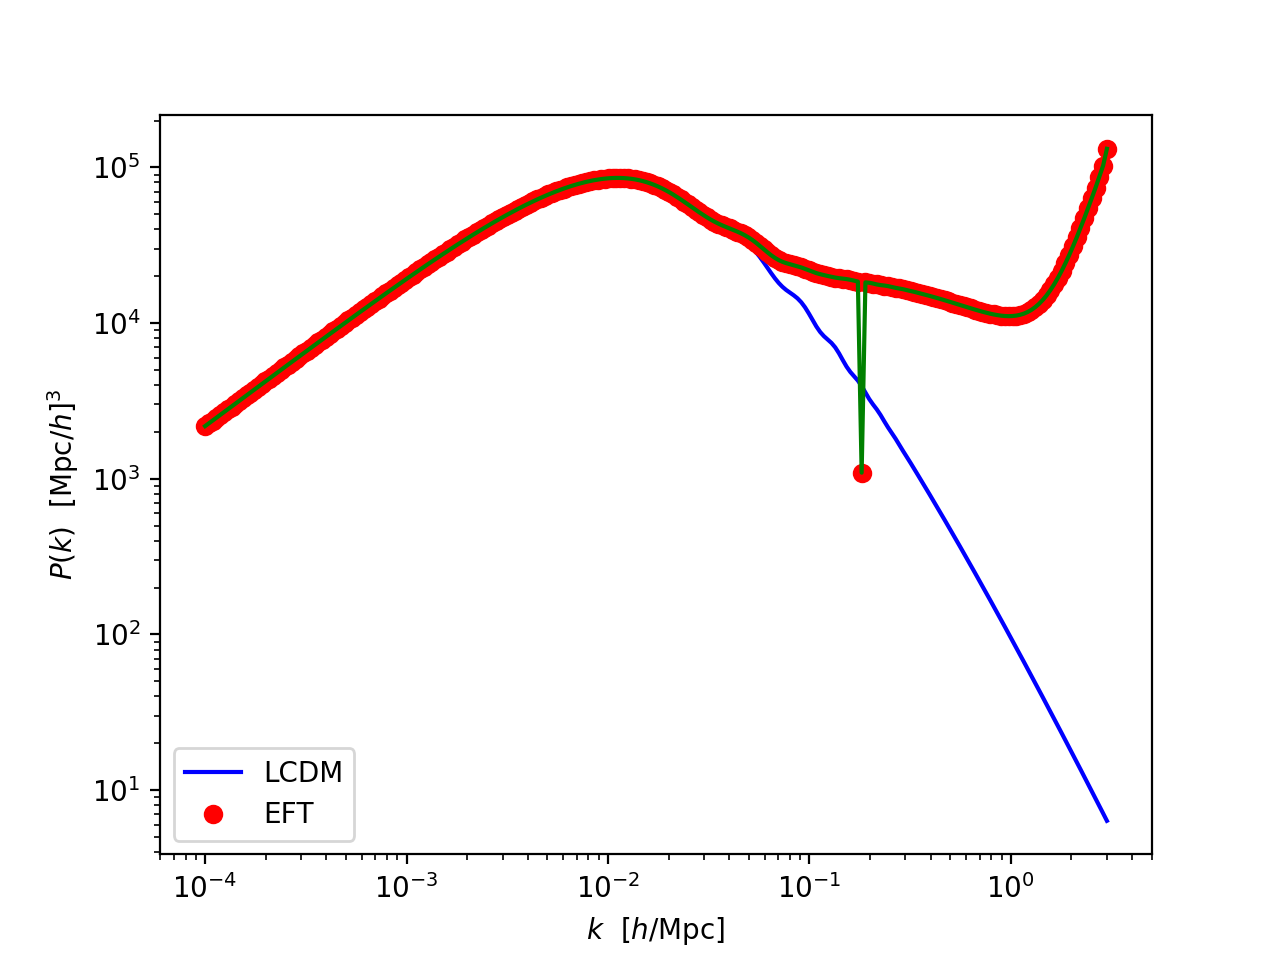

In [102]:
plt.figure()
plt.xscale('log');plt.yscale('log')
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
plt.plot(kk,Pk,'b-', label = 'LCDM')
plt.plot(kk1, lcdm_new, 'ro', label ="EFT")
plt.plot(kk1, Pk1+Pk, 'g-')
plt.legend(loc = "lower left")
plt.show()

<IPython.core.display.Javascript object>


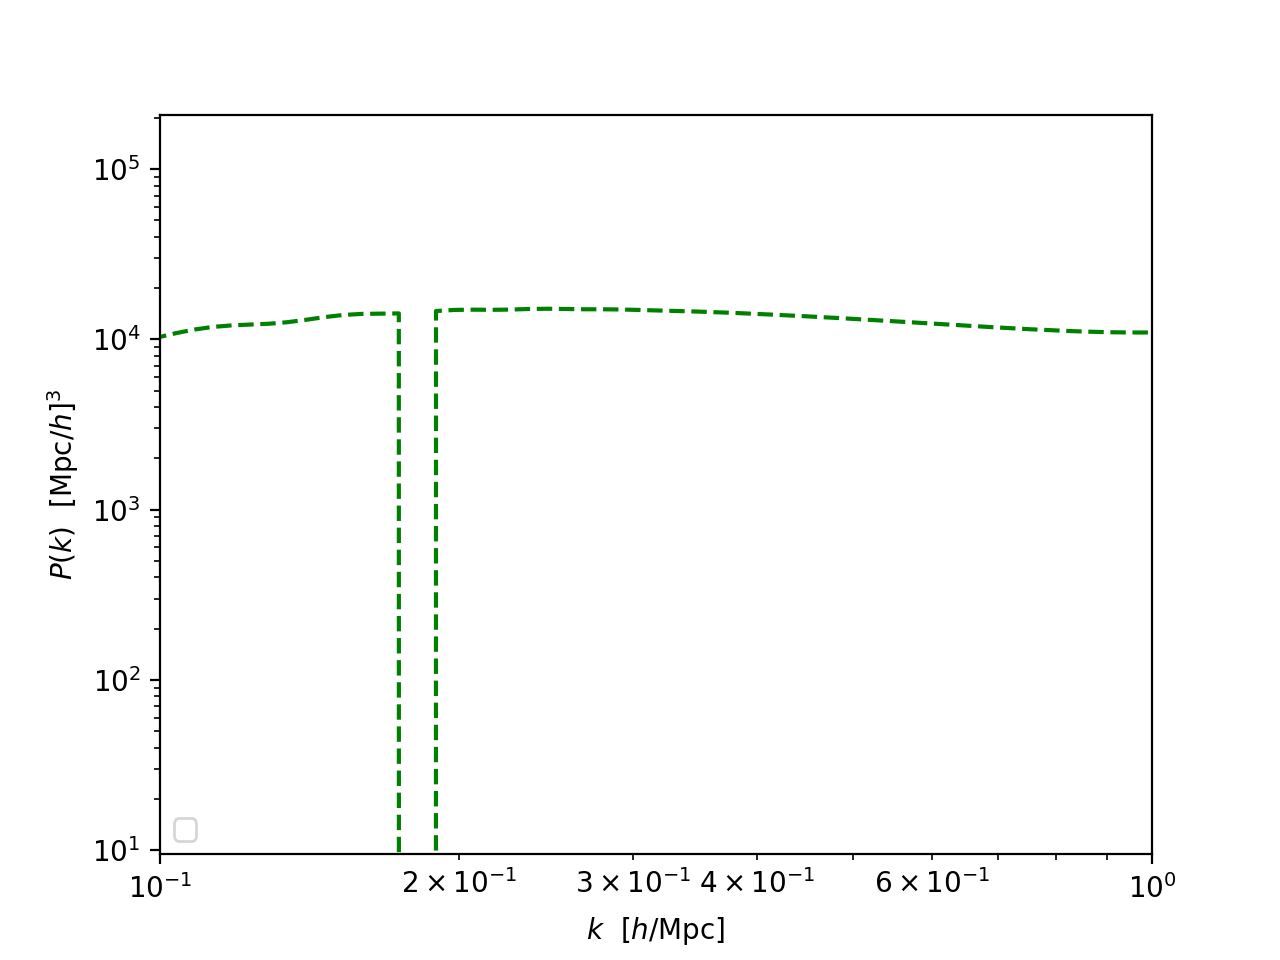

No handles with labels found to put in legend.


In [106]:
plt.figure()
plt.xscale('log');plt.yscale('log');plt.xlim(1.e-1, 1.); #plt.ylim(-5.e4, 5.e4)
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
plt.plot(kk1, Pk1, 'g--')
plt.legend(loc = "lower left")
plt.show()


In [128]:
delta_max = 0.1e5 # maximum difference in y between two points
delta = 0 # running correction value
data_cor = [] # corrected array
data_cor.append(lcdm_new[0:1])# we append two first points
kk_cor = []
kk_cor.append(kk1[0:1])
rng = len(lcdm_new)
#kk_c

for i in range(1, rng-2): # two first points are already appended
    i += 2
    delta_i = lcdm_new[i] - lcdm_new[i-1]
    if (kk1[i] < 1.) and (np.abs(delta_i) > delta_max):
        pass
    else:
        data_cor.append(lcdm_new[i])
        kk_cor.append(kk1[i]-delta)

len(kk_cor)

236

<IPython.core.display.Javascript object>


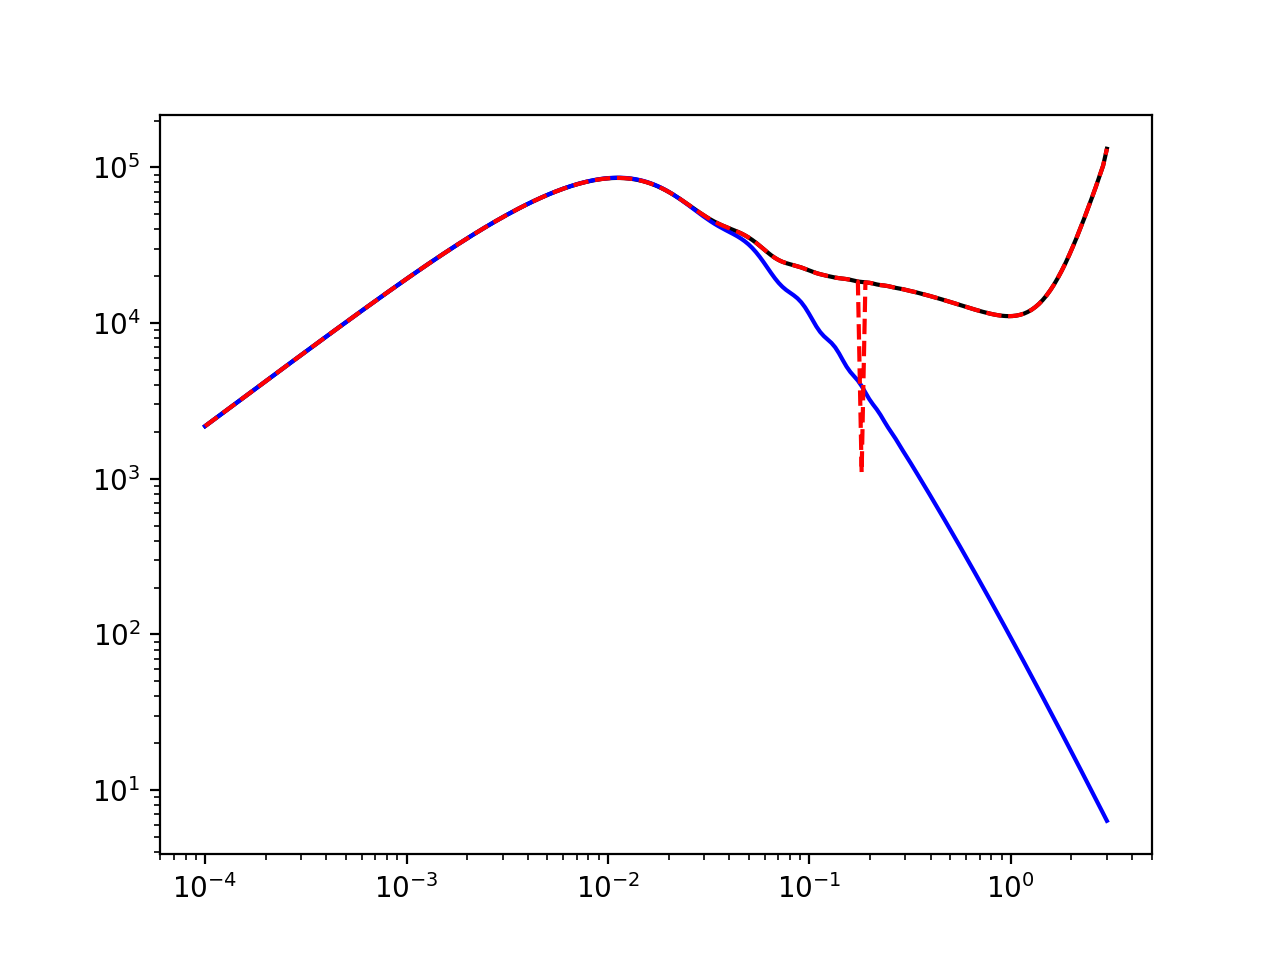

In [129]:
plt.figure()
plt.xscale("log"); plt.yscale("log")
plt.plot(kk_cor, data_cor, 'k-')
plt.plot(kk,Pk,'b-', label = 'LCDM')
plt.plot(kk1, lcdm_new, 'r--', label ="EFT")
plt.show()